# Подгружаем все что может понадобится

In [130]:
import pandas as pd
import traceback
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import warnings
import math
from copy import deepcopy
from tqdm import tqdm
import matplotlib as mpl
import platform
from collections import Counter
from IPython.core.display import HTML
import os
from copy import deepcopy
from sklearn.metrics import f1_score
import json
from sklearn.metrics import roc_auc_score
from copy import deepcopy
from catboost import CatBoostClassifier
from statistics import median
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.validation.np_iterators import TimeSeriesIterator
from datetime import timedelta
from lightautoml.utils.profiler import Profiler
from scipy import fft 
from math import *
p = Profiler()
p.change_deco_settings({'enabled': True})
sys.path.insert(0, "/Users/a185583357/Desktop/MMZip")
from backtest_period import backtest_year
from algo_stats import algo_stats
from algo_classes import Matching_Engine
from helpers import myround

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
tqdm.pandas()


warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10000




INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [131]:
#%pip install --user lightautoml

In [132]:
def y(x):
    return sin(x)

lst_x = []
lst_y = []
for i in range(10000):
    lst_x.append(i* pi/1000)
    lst_y.append(y(lst_x[-1]))

type(fft(np.array(lst_y))[2])

numpy.complex128

# Посмотрим на наши данные и почистим их

In [133]:
#fol = pd.read_csv("/Users/a185583357/Downloads/MMzip/fol/LKOH.txt", sep=",")

#TODO Inspect 20150923 - lots of errors there
date = "20150310"
try:
    fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/OrderLog" + date + ".txt", sep=',')
except:
    fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + ".txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
fol.tail()

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
26214948,26214949,FXIT,S,184457675,12836191,0,2461.0000,11285,nan,NaN
26214949,26214950,OGKB,S,184458220,12805810,0,0.2164,1000,nan,NaN
26214950,26214951,SBER,B,184458269,12819204,0,69.0900,30,nan,NaN
26214951,26214952,VZRZP,S,184458683,6479754,0,91.5000,20,nan,NaN
26214952,26214953,FXGD,S,184459634,12836206,0,519.0000,56500,nan,NaN


In [134]:


count = Counter(fol["SECCODE"]).most_common(30)
out = []
for share in count:
    out.append(share[0])
count

[('GAZP', 2997383),
 ('SBER', 2290044),
 ('SNGS', 2087074),
 ('CHMF', 1425078),
 ('RTKM', 1339749),
 ('LKOH', 1049386),
 ('ROSN', 844480),
 ('SBERP', 738394),
 ('VTBR', 714055),
 ('HYDR', 713783),
 ('SNGSP', 712352),
 ('MGNT', 704247),
 ('TRNFP', 694222),
 ('GMKN', 631399),
 ('NLMK', 593623),
 ('MTSS', 593605),
 ('MTLR', 581235),
 ('MOEX', 551809),
 ('URKA', 468585),
 ('TATN', 459544),
 ('ALRS', 456695),
 ('MAGN', 436832),
 ('EONR', 418226),
 ('FEES', 377768),
 ('AFKS', 366013),
 ('IRAO', 330446),
 ('MVID', 258997),
 ('NVTK', 251434),
 ('OGKB', 191821),
 ('SIBN', 191810)]

In [135]:
fol.head(5)

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1,ENRU,B,100000000,1,1,0.785,100000,nan,NaN
1,2,SBERP,B,100000000,2,1,52.400,10000,nan,NaN
2,3,AFKS,B,100000000,3,1,15.880,100,nan,NaN
3,4,AFLT,B,100000000,4,1,37.000,100,nan,NaN
4,5,ALRS,S,100000000,5,1,77.000,20000,nan,NaN


#  Соберем стакан из этого

Общая идея взята из статьи - https://habr.com/ru/post/276635/

In [136]:

share = "LKOH"
data = fol[fol["SECCODE"] == share]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(989860, 12)

In [137]:
data.head()

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,20,21,LKOH,B,100000000,21,1,2700.0,7,nan,NaN,20150310
1,264,265,LKOH,B,100000000,265,1,2720.0,100,nan,NaN,20150310
2,564,565,LKOH,S,100000000,565,1,2950.0,3098,nan,NaN,20150310
3,606,607,LKOH,B,100000000,607,1,2750.0,3,nan,NaN,20150310
4,611,612,LKOH,B,100000000,612,1,2775.0,42,nan,NaN,20150310


In [138]:
class Matching_Engine:
    def __init__(self):
        self.bid = SortedDict()  # descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.bid_FIFO = dict()
        self.ask_FIFO = dict()
        self.day = None
        self.share_name = "LKOH"
        self.trade_log = []

    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.share_name = data["SECCODE"]
            self.day = data["DATE"]

        if data["ACTION"] == 1:
            return self.check_add(data, new_trades=[])
        elif data["ACTION"] == 2:
            pass
        else:
            self.delete_order(data)

    ## First part - adding order

    def check_add(self, data, rec_flag=False, new_trades=[]):
        if (len(self.ask) > 0 and data['BUYSELL'] == "B" and
            (data["PRICE"] >= self.ask.peekitem(0)[0] or data["PRICE"] < 0.000001)) or \
                (len(self.bid) > 0 and data['BUYSELL'] == "S" and data["PRICE"] <= self.bid.peekitem(-1)[0]):
            if not rec_flag:
                self.add_order(data)
            return self.trade(data, new_trades=new_trades)
        else:
            if not rec_flag:
                self.add_order(data)

    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
                self.bid_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
                self.bid_FIFO[data["PRICE"]].append(data["ORDERNO"])
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
                self.ask_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
                self.ask_FIFO[data["PRICE"]].append(data["ORDERNO"])

    ## Second part - delete order

    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_FIFO[data["PRICE"]].pop(self.bid_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            if len(self.bid_FIFO[data["PRICE"]]) < 1:
                del self.bid_FIFO[data["PRICE"]]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            self.ask_FIFO[data["PRICE"]].pop(self.ask_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            if len(self.ask_FIFO[data["PRICE"]]) < 1:
                del self.ask_FIFO[data["PRICE"]]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    ## Third part - match order
    def trade(self, data, new_trades=[]):
        if data['BUYSELL'] == "B":
            return self.exec_buy_order(data, new_trades=new_trades)
        else:
            return self.exec_sell_order(data, new_trades=new_trades)

    def exec_sell_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            sell_order = self.ask_active_order[data["ORDERNO"]]
            tradeprice = self.bid.peekitem(-1)[0]
            order_no = self.bid_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            buy_order = self.bid_active_order[order_no]
            if buy_order[1] > sell_order[1]:
                self.bid_active_order[order_no] = (self.bid_active_order[order_no][0],
                                                   buy_order[1] - sell_order[1])
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "B"

                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no

                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "B"
                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0],
                                                          sell_order[1] - buy_order[1])
                # TODO не учтено полное пробитие стакана!!
                if len(self.bid) == 0:
                    #reject стакан пробит
                    go_trade = False
                    #print("пробит стакан")
                elif self.bid.peekitem(-1)[0] >= sell_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "S"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                print("Maybe error", buy_order, sell_order)
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.ask[data["PRICE"]] -= data["VOLUME"]
                # return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    def exec_buy_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            buy_order = self.bid_active_order[data["ORDERNO"]]
            tradeprice = self.ask.peekitem(0)[0]
            order_no = self.ask_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            sell_order = self.ask_active_order[order_no]
            if sell_order[1] > buy_order[1]:
                self.ask_active_order[order_no] = (self.ask_active_order[order_no][0],
                                                   sell_order[1] - buy_order[1])
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = self.ask_FIFO[tradeprice][0]
                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0],
                                                          buy_order[1] - sell_order[1])
                if len(self.ask) == 0:
                    #reject стакан пробит
                    go_trade = False
                elif self.ask.peekitem(0)[0] <= buy_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            # TODO Мне кажется здесь потенциальная ошибка, не предусмотрено что аркет мейкер заявка может в кого то удариться
            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "B"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                print("Maybe error", buy_order, sell_order)
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.bid[data["PRICE"]] -= data["VOLUME"]
                return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    ## Others

    def clean_dom(self):
        self.__init__()


In [141]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX_old/OrderLog" + date + "/isebergs_" + share + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        #print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 989860/989860 [00:05<00:00, 190067.65it/s]


In [142]:
dom.trade_log[-1]

[2722.3, 87, 12836091, 12552626, 236840.1, 183958905, 26212999, 'B']

# Теперь сделаем заготовку для ML, для этого соберем numpy array снапшота стакана и последих трейдов

In [143]:
deep = 1

In [144]:
def RSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = deepcopy(0 * diff)
    down_chg = deepcopy(0 * diff)
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
   
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.mean()
    down_chg_avg = down_chg.mean()
    
    if down_chg_avg == 0:
        return 100.0
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [145]:
def VWAP(trade_log, record, vwap, top_price, min_price, timerange=1):
    timenow = datetime.datetime.strptime(str(record["TIME"]), '%H%M%S%f')
    time_log = pd.to_datetime(pd.Series(np.array(trade_log)[:, -3]), format='%H%M%S%f')
    trades_window = np.array(trade_log)[time_log > (timenow - datetime.timedelta(seconds=timerange))]
    if trades_window.shape[0] == 0:
        return vwap, top_price, min_price
    else:
        return sum(trades_window[:, 0].astype(float) * trades_window[:, 1].astype(int)) /  sum(trades_window[:, 1].astype(int)), max(trades_window[:, 0].astype(float)), min(trades_window[:, 0].astype(float))

In [146]:
tmp = datetime.datetime.strptime(str(record["TIME"]), '%H%M%S%f')
time_log = pd.to_datetime(pd.Series(np.array(dom.trade_log)[:, -3]), format='%H%M%S%f')
tmp = np.array(dom.trade_log)[time_log > (tmp - datetime.timedelta(seconds=500))]
max(tmp[:, 0].astype(float))

2722.3

In [147]:
sma5, sma10, sma30, sma50, sma100 = 0, 0, 0, 0, 0
ema5, ema10, ema30, ema100 = 0, 0, 0, 0
std10, std50, std100, std1000 = 0, 0, 0, 0
rsi14, rsi50, rsi100, rsi300 = 0, 0, 0, 0
vwap1, vwap30, vwap60 = 0, 0, 0
top_price1, top_price30, top_price60 = 0, 0, 0
min_price1, min_price30, min_price60 = 0, 0, 0

def get_technical_indicator(change, trade_log, output, record):
    #TODO это однозначно можно сделать оптимальнее!!
    global deep
    global sma5, sma10, sma30, sma50, sma100
    global ema5, ema10, ema30, ema100
    global std10, std50, std100, std1000 
    global rsi14, rsi50, rsi100, rsi300
    global vwap1, vwap30, vwap60
    global top_price1, top_price30, top_price60
    global min_price1, min_price30, min_price60
    if change != 0:        
        sma5 = np.array(trade_log[-5:])[:, 0].astype(float).mean()
        sma10 = np.array(trade_log[-10:])[:, 0].astype(float).mean()
        sma30 = np.array(trade_log[-30:])[:, 0].astype(float).mean()
        sma50 = np.array(trade_log[-50:])[:, 0].astype(float).mean()
        sma100 = np.array(trade_log[-100:])[:, 0].astype(float).mean()
        #EMA
        ema5 = pd.DataFrame(np.array(trade_log[-5:])[:, 0].astype(float)).ewm(span=5).mean().iat[-1, 0]
        ema10 = pd.DataFrame(np.array(trade_log[-10:])[:, 0].astype(float)).ewm(span=10).mean().iat[-1, 0]
        ema30 = pd.DataFrame(np.array(trade_log[-30:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        ema100 = pd.DataFrame(np.array(trade_log[-100:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        #std
        std10 = np.array(trade_log[-10:])[:, 0].astype(float).std()
        std50 = np.array(trade_log[-50:])[:, 0].astype(float).std()
        std100 = np.array(trade_log[-100:])[:, 0].astype(float).std()
        std1000 = np.array(trade_log[-1000:])[:, 0].astype(float).std()
        #RSI
        rsi14 = RSI(pd.Series(np.array(trade_log[-14:])[:, 0].astype(float)), 14)
        rsi50 = RSI(pd.Series(np.array(trade_log[-50:])[:, 0].astype(float)), 50)
        rsi100 = RSI(pd.Series(np.array(trade_log[-100:])[:, 0].astype(float)), 100)
        rsi300 = RSI(pd.Series(np.array(trade_log[-300:])[:, 0].astype(float)), 300)
        #VWAP, top, min
        vwap1, top_price1, min_price1 = VWAP(trade_log[-1000:], record, vwap1, top_price1, min_price1, timerange=1)
        vwap30, top_price30, min_price30 = VWAP(trade_log[-3000:], record, vwap30, top_price30, min_price60, timerange=30)
        vwap60, top_price60, min_price60 = VWAP(trade_log[-5000:], record, vwap60, top_price30, min_price60, timerange=60)
    output[deep * 4 + 7] = sma5
    output[deep * 4 + 8] = sma10
    output[deep * 4 + 9] = sma30
    output[deep * 4 + 10] = sma50
    output[deep * 4 + 11] = sma100
    #EMA
    output[deep * 4 + 12] = ema5
    output[deep * 4 + 13] = ema10
    output[deep * 4 + 14] = ema30
    output[deep * 4 + 15] = ema100
    #std
    output[deep * 4 + 16] = std10
    output[deep * 4 + 17] = std50
    output[deep * 4 + 18] = std100
    output[deep * 4 + 19] = std1000
    #RSI
    output[deep * 4 + 20] = rsi14
    output[deep * 4 + 21] = rsi50
    output[deep * 4 + 22] = rsi100
    output[deep * 4 + 23] = rsi300
    #VWAP
    output[deep * 4 + 24] = vwap1
    output[deep * 4 + 25] = vwap30
    output[deep * 4 + 26] = vwap60
    #top
    output[deep * 4 + 27] = top_price1
    output[deep * 4 + 28] = top_price30
    output[deep * 4 + 29] = top_price60
    #min
    output[deep * 4 + 30] = min_price1
    output[deep * 4 + 31] = min_price30
    output[deep * 4 + 32] = min_price60
    return output

In [148]:
def construct_raw(dom, deep, raw_data, record):
    output = [0] * (deep * 4 + 33)
    trade_log = dom.trade_log
    bids = list(dom.bid.items())
    asks = list(dom.ask.items())
    for i in range(0, deep):
        if len(bids) > i:
            #print(bids[-1], i)
            output[(2 * deep) - 2 * i - 1] = bids[-i - 1][1]
            output[(2 * deep) - 2 * i - 2] = bids[-i - 1][0]
        if len(asks) > i:
            #print(asks, i)
            output[(2 * deep) + 2 * i + 1] = asks[i][1]
            output[(2 * deep) + 2 * i] = asks[i][0]
    if len(dom.trade_log) > 0:
        #print(dom.trade_log[-1])
        output[deep * 4] = dom.trade_log[-1][0]
        output[deep * 4 + 1] = dom.trade_log[-1][1]
        if output[deep * 4 + 2] == "B":
            output[deep * 4 + 2] = -1
        else:
            output[deep * 4 + 2] = 1
        change = raw_data[-1][deep * 4] - output[deep * 4]
        if change == 0:
            output[deep * 4 + 3] = 0
        elif change > 0:
            output[deep * 4 + 3] = -1
        else:
            output[deep * 4 + 3] = 1
            
        output[deep * 4 + 4] = dom.trade_log[-1][-3]
    output[deep * 4 + 5] = int(record["DATE"])
    output[deep * 4 + 6] = record["TIME"]
    if len(trade_log) > 50:
        output = get_technical_indicator(change, trade_log, output, record)
    
    
    return output

In [152]:
def get_data(date, records, deep):
    dom = Matching_Engine()
    errors = 0
    isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + share + date + ".csv", index_col=0).to_dict()["vol"]
    raw_data = []

    for i in tqdm(range(len(records))):
        record = records[i].copy()
        if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
            record["VOLUME"] = isebergs[record["ORDERNO"]]
        try:
            out = dom.check_order(record)
            raw_data.append(construct_raw(dom, deep, raw_data, record))
        except Exception as e:
            #print(e)
            if record["ACTION"] == 1:
                print("MAYBE Some problem, cant add order")
                dom.check_order(record)
                raise Exception
            raw_data.append(construct_raw(dom, deep, raw_data, record))
            errors += 1
    return raw_data


raw_data = get_data(date, records, deep)
#raw_data[1000]
len(raw_data)

100%|██████████| 989860/989860 [19:59<00:00, 824.96it/s]  


989860

In [153]:
def find_nearest(raw, future1, future30, future60):
    dt = raw.Time
    nearest1 = future1.iloc[future1.index.get_loc(dt, method='nearest')]
    nearest30 = future30.iloc[future30.index.get_loc(dt, method='nearest')]
    nearest60 = future60.iloc[future60.index.get_loc(dt, method='nearest')]
    raw["FutureVWAP1"] = nearest1["FutureVWAP1"]
    raw["MIN1"] = nearest1["MIN1"]
    raw["TOP1"] = nearest1["TOP1"]    
    raw["FutureVWAP30"] = nearest30["FutureVWAP30"]
    raw["MIN30"] = nearest30["MIN30"]
    raw["TOP30"] = nearest30["TOP30"]
    raw["FutureVWAP60"] = nearest60["FutureVWAP60"]
    raw["MIN60"] = nearest60["MIN60"]
    raw["TOP60"] = nearest60["TOP60"]
    return raw
    


def create_future_vwap(snapchot):
    snapchot["FutureVWAP1"] = deepcopy(snapchot["VWAP1"])
    snapchot["FutureVWAP30"] = deepcopy(snapchot["VWAP30"])
    snapchot["FutureVWAP60"] = deepcopy(snapchot["VWAP60"])
    future1 = deepcopy(snapchot.shift(freq=-timedelta(seconds=1)))
    future30 = deepcopy(snapchot.shift(freq=-timedelta(seconds=30)))
    future60 = deepcopy(snapchot.shift(freq=-timedelta(seconds=60)))
    try:
        snapchot = snapchot.parallel_apply(find_nearest, args=(future1, future30, future60), axis=1)
    except:
        snapchot = snapchot.progress_apply(find_nearest, args=(future1, future30, future60), axis=1)
    snapchot["Difference1"] = snapchot["FutureVWAP1"] - snapchot["VWAP1"]
    snapchot["Difference30"] = snapchot["FutureVWAP30"] - snapchot["VWAP30"]
    snapchot["Difference60"] = snapchot["FutureVWAP60"] - snapchot["VWAP60"]
    snapchot["IsUp1"] = np.sign(snapchot["Difference1"])
    snapchot["IsUp30"] = np.sign(snapchot["Difference30"])
    snapchot["IsUp60"] = np.sign(snapchot["Difference60"])
    return snapchot
    

In [154]:
pd.DataFrame(raw_data).to_csv("../" + share + date + ".csv")

In [155]:
raw_data = pd.read_csv("../" + share + date + ".csv").drop(['Unnamed: 0'], axis=1)
raw_data = raw_data.values.tolist()

In [156]:
share

'LKOH'

In [157]:
def get_df_y(raw_data, deep):
    columns = []
    for col in ["Bid", "Ask"]:
        for num in range(1, 1 + deep):
            if col == "Bid":
                num = deep - num + 1
            columns.append(col + "Price" + str(num))
            columns.append(col + "Volume" + str(num))
    dupl_col = deepcopy(columns)
    columns += ["Last Trade Price"] + ["Last Trade Volume"] + ["Side"] + ["isNewTrade"] + \
    ["LastDealTime"] + ["Date"] + ["Time"] + ["SMA5"] + ["SMA10"] + ["SMA30"] + ["SMA50"] + ["SMA100"] +\
    ["EMA5"] + ["EMA10"] + ["EMA30"] + ["EMA100"] + ["STD10"] + ["STD50"] + ["STD100"] + ["STD1000"] +\
    ["RSI14"] + ["RSI50"] + ["RSI100"] + ["RSI300"] + ["VWAP1"] + ["VWAP30"] + ["VWAP60"] +\
    ["TOP1"] + ["TOP30"] + ["TOP60"] + ["MIN1"] + ["MIN30"] + ["MIN60"] 
    snapschot = pd.DataFrame(np.stack(raw_data, axis=0), columns=columns)
    snapschot["LiquidityBid"] = 0
    snapschot["LiquidityAsk"] = 0
    for i in range(1, 1 + deep):
        snapschot['LiquidityAsk'] += snapschot["AskVolume" + str(i)]
        snapschot["LiquidityBid"] += snapschot["BidVolume" + str(i)]

    snapschot["BidLiquidityRatio"] = snapschot["LiquidityBid"] / (snapschot["LiquidityBid"] + snapschot["LiquidityAsk"])
    copy_snapschot = deepcopy(snapschot)
    snapschot = snapschot[snapschot["Time"] > 100002000.0]
    
    snapschot.drop_duplicates(subset=dupl_col,inplace=True)
    
    snapschot.index = snapschot["Time"]
    snapschot = snapschot[~snapschot.index.duplicated(keep='last')]
    tmp_time = deepcopy(snapschot.index)
    snapschot["Time"] = pd.to_datetime((snapschot["Time"]), format='%H%M%S%f')
    snapschot.index = snapschot["Time"]
    snapschot = create_future_vwap(snapschot)
    snapschot["Time"] = tmp_time
    y = np.array(snapschot["IsUp60"])
    drop_col = ["IsUp1", "IsUp30", "IsUp60", "Difference1", "Difference30", "Difference60",
                "FutureVWAP1", "FutureVWAP30", "FutureVWAP60", "Time"]
    df = snapschot.drop(drop_col, axis=1)
    return df, np.array(y), snapschot, copy_snapschot

df, y, snapschot, copy_snapschot = get_df_y(raw_data, deep)
snapschot.to_csv(share + date + ".csv")

## Attention надо обязательно сделать задержку и смещение

Данные готовы, по одному дню сбера. теперь посмотрим на них

## Здесь будут графики и анализ существующих данных

In [88]:
copy_snapschot[30000:30005]

,BidPrice5,BidVolume5,BidPrice4,BidVolume4,BidPrice3,BidVolume3,BidPrice2,BidVolume2,BidPrice1,BidVolume1,...,VWAP60,TOP1,TOP30,TOP60,MIN1,MIN30,MIN60,LiquidityBid,LiquidityAsk,BidLiquidityRatio
30000,334.9,780.0,334.95,4090.0,335.0,6380.0,335.05,1210.0,335.1,550.0,...,335.249565,335.25,335.25,335.25,335.15,335.15,335.15,13010.0,18450.0,0.413541
30001,334.9,780.0,334.95,4090.0,335.0,6380.0,335.05,1210.0,335.1,550.0,...,335.249565,335.25,335.25,335.25,335.15,335.15,335.15,13010.0,18450.0,0.413541
30002,334.9,780.0,334.95,4090.0,335.0,6380.0,335.05,1210.0,335.1,550.0,...,335.249565,335.25,335.25,335.25,335.15,335.15,335.15,13010.0,18450.0,0.413541
30003,334.9,780.0,334.95,4090.0,335.0,6380.0,335.05,800.0,335.1,550.0,...,335.249565,335.25,335.25,335.25,335.15,335.15,335.15,12600.0,18450.0,0.405797
30004,334.9,780.0,334.95,4090.0,335.0,6380.0,335.05,800.0,335.1,550.0,...,335.249565,335.25,335.25,335.25,335.15,335.15,335.15,12600.0,18860.0,0.400509


In [89]:
copy_snapschot.shape, len(records), len(raw_data)

((128597, 56), 128597, 128597)

In [90]:
visu_data = snapschot#[1500:]

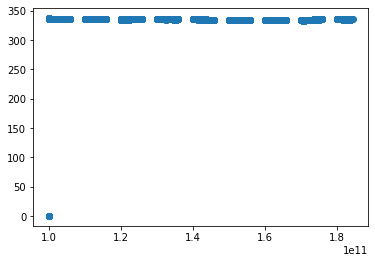

In [91]:
plt.scatter(visu_data["Time"], visu_data["Last Trade Price"])

In [92]:
pd.to_datetime((snapschot["Time"]), format='%H%M%S%f')

Time
1900-01-01 10:00:00.000000   1900-01-01 10:00:00.000000
1900-01-01 10:00:00.523397   1900-01-01 10:00:00.523397
1900-01-01 10:00:00.543390   1900-01-01 10:00:00.543390
1900-01-01 10:00:00.544150   1900-01-01 10:00:00.544150
1900-01-01 10:00:00.557825   1900-01-01 10:00:00.557825
                                        ...            
1900-01-01 18:40:16.183874   1900-01-01 18:40:16.183874
1900-01-01 18:40:21.004303   1900-01-01 18:40:21.004303
1900-01-01 18:40:44.352565   1900-01-01 18:40:44.352565
1900-01-01 18:43:26.296051   1900-01-01 18:43:26.296051
1900-01-01 18:45:21.000387   1900-01-01 18:45:21.000387
Name: Time, Length: 68938, dtype: datetime64[ns]

In [93]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(3) 
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(df)[train_index], np.array(df)[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 17233 17234 17235] TEST: [17236 17237 17238 ... 34467 34468 34469]
TRAIN: [    0     1     2 ... 34467 34468 34469] TEST: [34470 34471 34472 ... 51701 51702 51703]
TRAIN: [    0     1     2 ... 51701 51702 51703] TEST: [51704 51705 51706 ... 68935 68936 68937]


# Тут рандомные предсказания

In [94]:
def random_predict(train_data):
    return np.around(np.random.rand(train_data.shape[0]) * 2 - 1)

In [95]:
def const_predict(train_data, pred):
    out = np.zeros(train_data.shape[0]) + pred
    return out

In [96]:
Counter(random_predict(X_test)), f1_score(y_test, random_predict(X_test), average='micro')

(Counter({-0.0: 8596, 1.0: 4286, -1.0: 4352}), 0.24712777068585356)

In [97]:
const = Counter(y_test).most_common(1)[0][0]
Counter(const_predict(X_test, const)), f1_score(y_test, const_predict(X_test, const), average='micro')

(Counter({1.0: 17234}), 0.5847162585586632)

In [98]:
Counter(y_test)

Counter({1.0: 10077, -1.0: 7088, 0.0: 69})

## Тут Random forest

In [99]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [100]:
Counter(rf.predict(X_train)), f1_score(y_train, rf.predict(X_train), average='micro')

(Counter({1.0: 27156, -1.0: 23662, 0.0: 886}), 1.0)

In [101]:
Counter(rf.predict(X_test)), f1_score(y_test, rf.predict(X_test), average='micro')

(Counter({1.0: 9088, -1.0: 8146}), 0.7197400487408611)

In [102]:
np.argsort(rf.feature_importances_)[::-1]

array([39, 24, 48, 45, 30, 51, 41, 40, 38, 42, 37, 44, 29, 36, 33, 34, 28,
       27, 47, 35, 32, 50,  3, 54, 31, 26,  5, 53, 43, 52, 21, 46,  1,  7,
       19, 49, 15, 13, 20, 17,  9, 16, 10, 11, 12,  8, 14,  0, 18,  6,  4,
        2, 23, 22, 25])

Feature ranking:
1. feature RSI14 (0.078748)
2. feature LastDealTime (0.059064)
3. feature TOP60 (0.047457)
4. feature VWAP60 (0.042854)
5. feature SMA100 (0.042171)
6. feature MIN60 (0.041151)
7. feature RSI100 (0.039220)
8. feature RSI50 (0.038334)
9. feature STD1000 (0.033430)
10. feature RSI300 (0.033039)
11. feature STD100 (0.030428)
12. feature VWAP30 (0.029185)
13. feature SMA50 (0.029143)
14. feature STD50 (0.028338)
15. feature EMA30 (0.027206)
16. feature EMA100 (0.025798)
17. feature SMA30 (0.024588)
18. feature SMA10 (0.022893)
19. feature TOP30 (0.022576)
20. feature STD10 (0.018551)
21. feature EMA10 (0.018347)
22. feature MIN30 (0.017809)
23. feature BidVolume4 (0.015177)
24. feature BidLiquidityRatio (0.015148)
25. feature EMA5 (0.015121)
26. feature SMA5 (0.014527)
27. feature BidVolume3 (0.013662)
28. feature LiquidityAsk (0.012465)
29. feature VWAP1 (0.011605)
30. feature LiquidityBid (0.011402)
31. feature Last Trade Volume (0.009343)
32. feature TOP1 (0.008739)
33.

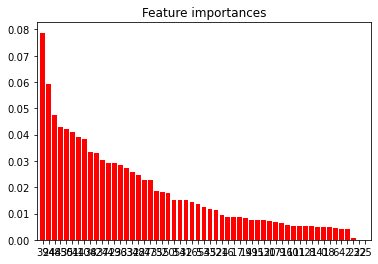

In [103]:
def get_importance(model, importance):    
    indices = np.argsort(importance)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, df.columns[indices[f]], importance[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(df.columns[indices], importance[indices],
            color="r", align="center")
    plt.xticks(df.columns[indices], indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    

get_importance(rf, rf.feature_importances_)

## Тут Catboost

In [104]:
cbst = CatBoostClassifier()
cbst.fit(pd.DataFrame(X_train), y_train)


Learning rate set to 0.096764
0:	learn: 1.0168107	total: 91.2ms	remaining: 1m 31s
1:	learn: 0.9489546	total: 119ms	remaining: 59.2s
2:	learn: 0.8923753	total: 136ms	remaining: 45.1s
3:	learn: 0.8449539	total: 157ms	remaining: 39.2s
4:	learn: 0.8027440	total: 173ms	remaining: 34.4s
5:	learn: 0.7653991	total: 188ms	remaining: 31.2s
6:	learn: 0.7306962	total: 208ms	remaining: 29.5s
7:	learn: 0.7037332	total: 223ms	remaining: 27.7s
8:	learn: 0.6791489	total: 238ms	remaining: 26.2s
9:	learn: 0.6566866	total: 258ms	remaining: 25.5s
10:	learn: 0.6387581	total: 273ms	remaining: 24.5s
11:	learn: 0.6201106	total: 289ms	remaining: 23.8s
12:	learn: 0.6040880	total: 308ms	remaining: 23.4s
13:	learn: 0.5892008	total: 323ms	remaining: 22.7s
14:	learn: 0.5753105	total: 338ms	remaining: 22.2s
15:	learn: 0.5615616	total: 360ms	remaining: 22.2s
16:	learn: 0.5503023	total: 376ms	remaining: 21.7s
17:	learn: 0.5413818	total: 396ms	remaining: 21.6s
18:	learn: 0.5320112	total: 420ms	remaining: 21.7s
19:	learn

162:	learn: 0.1998123	total: 2.89s	remaining: 14.8s
163:	learn: 0.1990700	total: 2.91s	remaining: 14.8s
164:	learn: 0.1981641	total: 2.94s	remaining: 14.9s
165:	learn: 0.1975513	total: 2.96s	remaining: 14.9s
166:	learn: 0.1961850	total: 2.98s	remaining: 14.9s
167:	learn: 0.1954422	total: 3.01s	remaining: 14.9s
168:	learn: 0.1946888	total: 3.03s	remaining: 14.9s
169:	learn: 0.1935645	total: 3.04s	remaining: 14.9s
170:	learn: 0.1928267	total: 3.06s	remaining: 14.9s
171:	learn: 0.1925395	total: 3.08s	remaining: 14.8s
172:	learn: 0.1916150	total: 3.1s	remaining: 14.8s
173:	learn: 0.1906663	total: 3.12s	remaining: 14.8s
174:	learn: 0.1899513	total: 3.13s	remaining: 14.8s
175:	learn: 0.1888638	total: 3.15s	remaining: 14.7s
176:	learn: 0.1877096	total: 3.16s	remaining: 14.7s
177:	learn: 0.1871093	total: 3.18s	remaining: 14.7s
178:	learn: 0.1861005	total: 3.19s	remaining: 14.6s
179:	learn: 0.1854436	total: 3.21s	remaining: 14.6s
180:	learn: 0.1844226	total: 3.22s	remaining: 14.6s
181:	learn: 0

330:	learn: 0.1039155	total: 5.8s	remaining: 11.7s
331:	learn: 0.1036681	total: 5.82s	remaining: 11.7s
332:	learn: 0.1033732	total: 5.84s	remaining: 11.7s
333:	learn: 0.1030896	total: 5.86s	remaining: 11.7s
334:	learn: 0.1028604	total: 5.88s	remaining: 11.7s
335:	learn: 0.1026376	total: 5.89s	remaining: 11.6s
336:	learn: 0.1023823	total: 5.91s	remaining: 11.6s
337:	learn: 0.1022076	total: 5.92s	remaining: 11.6s
338:	learn: 0.1019637	total: 5.94s	remaining: 11.6s
339:	learn: 0.1016416	total: 5.96s	remaining: 11.6s
340:	learn: 0.1013953	total: 5.97s	remaining: 11.5s
341:	learn: 0.1010397	total: 5.99s	remaining: 11.5s
342:	learn: 0.1007605	total: 6s	remaining: 11.5s
343:	learn: 0.1004082	total: 6.02s	remaining: 11.5s
344:	learn: 0.1001699	total: 6.04s	remaining: 11.5s
345:	learn: 0.0998420	total: 6.05s	remaining: 11.4s
346:	learn: 0.0995765	total: 6.07s	remaining: 11.4s
347:	learn: 0.0993050	total: 6.09s	remaining: 11.4s
348:	learn: 0.0990720	total: 6.11s	remaining: 11.4s
349:	learn: 0.09

498:	learn: 0.0674477	total: 8.5s	remaining: 8.54s
499:	learn: 0.0673319	total: 8.52s	remaining: 8.52s
500:	learn: 0.0671596	total: 8.54s	remaining: 8.5s
501:	learn: 0.0670771	total: 8.55s	remaining: 8.48s
502:	learn: 0.0669817	total: 8.57s	remaining: 8.47s
503:	learn: 0.0667731	total: 8.59s	remaining: 8.45s
504:	learn: 0.0666814	total: 8.6s	remaining: 8.43s
505:	learn: 0.0664712	total: 8.62s	remaining: 8.42s
506:	learn: 0.0662375	total: 8.64s	remaining: 8.4s
507:	learn: 0.0660582	total: 8.65s	remaining: 8.38s
508:	learn: 0.0659014	total: 8.67s	remaining: 8.36s
509:	learn: 0.0657064	total: 8.68s	remaining: 8.34s
510:	learn: 0.0656493	total: 8.7s	remaining: 8.32s
511:	learn: 0.0655118	total: 8.71s	remaining: 8.31s
512:	learn: 0.0653980	total: 8.73s	remaining: 8.29s
513:	learn: 0.0653342	total: 8.74s	remaining: 8.27s
514:	learn: 0.0653134	total: 8.76s	remaining: 8.25s
515:	learn: 0.0652006	total: 8.78s	remaining: 8.24s
516:	learn: 0.0650372	total: 8.8s	remaining: 8.22s
517:	learn: 0.0648

667:	learn: 0.0490893	total: 11.2s	remaining: 5.58s
668:	learn: 0.0490327	total: 11.2s	remaining: 5.56s
669:	learn: 0.0489776	total: 11.3s	remaining: 5.54s
670:	learn: 0.0489119	total: 11.3s	remaining: 5.53s
671:	learn: 0.0488392	total: 11.3s	remaining: 5.51s
672:	learn: 0.0487993	total: 11.3s	remaining: 5.5s
673:	learn: 0.0487077	total: 11.3s	remaining: 5.48s
674:	learn: 0.0485712	total: 11.3s	remaining: 5.46s
675:	learn: 0.0484643	total: 11.4s	remaining: 5.45s
676:	learn: 0.0483917	total: 11.4s	remaining: 5.43s
677:	learn: 0.0482762	total: 11.4s	remaining: 5.41s
678:	learn: 0.0481883	total: 11.4s	remaining: 5.39s
679:	learn: 0.0481037	total: 11.4s	remaining: 5.38s
680:	learn: 0.0480217	total: 11.4s	remaining: 5.36s
681:	learn: 0.0479637	total: 11.5s	remaining: 5.34s
682:	learn: 0.0478653	total: 11.5s	remaining: 5.33s
683:	learn: 0.0478130	total: 11.5s	remaining: 5.31s
684:	learn: 0.0477252	total: 11.5s	remaining: 5.29s
685:	learn: 0.0476419	total: 11.5s	remaining: 5.28s
686:	learn: 0

831:	learn: 0.0385867	total: 13.9s	remaining: 2.8s
832:	learn: 0.0385417	total: 13.9s	remaining: 2.79s
833:	learn: 0.0385113	total: 13.9s	remaining: 2.77s
834:	learn: 0.0384766	total: 13.9s	remaining: 2.75s
835:	learn: 0.0383977	total: 13.9s	remaining: 2.73s
836:	learn: 0.0383606	total: 14s	remaining: 2.72s
837:	learn: 0.0383408	total: 14s	remaining: 2.7s
838:	learn: 0.0382688	total: 14s	remaining: 2.68s
839:	learn: 0.0382238	total: 14s	remaining: 2.67s
840:	learn: 0.0382056	total: 14s	remaining: 2.65s
841:	learn: 0.0381802	total: 14s	remaining: 2.63s
842:	learn: 0.0381164	total: 14s	remaining: 2.62s
843:	learn: 0.0380287	total: 14.1s	remaining: 2.6s
844:	learn: 0.0379508	total: 14.1s	remaining: 2.58s
845:	learn: 0.0378867	total: 14.1s	remaining: 2.57s
846:	learn: 0.0378564	total: 14.1s	remaining: 2.55s
847:	learn: 0.0378220	total: 14.1s	remaining: 2.53s
848:	learn: 0.0377463	total: 14.2s	remaining: 2.52s
849:	learn: 0.0377308	total: 14.2s	remaining: 2.5s
850:	learn: 0.0376889	total: 1

994:	learn: 0.0314429	total: 16.6s	remaining: 83.3ms
995:	learn: 0.0314073	total: 16.6s	remaining: 66.6ms
996:	learn: 0.0313574	total: 16.6s	remaining: 50ms
997:	learn: 0.0313090	total: 16.6s	remaining: 33.3ms
998:	learn: 0.0312786	total: 16.6s	remaining: 16.7ms
999:	learn: 0.0312549	total: 16.7s	remaining: 0us


In [105]:
Counter(cbst.predict(np.array(X_train)).ravel()), f1_score(y_train, cbst.predict(np.array(X_train)), average='micro')

(Counter({1.0: 27175, -1.0: 23674, 0.0: 855}), 0.9973503017174686)

In [106]:
Counter(cbst.predict(X_test).ravel()), f1_score(y_test, cbst.predict(X_test), average='micro')

(Counter({1.0: 9400, -1.0: 7834}), 0.772948822095857)

Feature ranking:
1. feature VWAP60 (8.202991)
2. feature TOP60 (7.588480)
3. feature MIN60 (6.769113)
4. feature RSI14 (5.726914)
5. feature RSI50 (5.317618)
6. feature STD1000 (5.287768)
7. feature RSI100 (5.246546)
8. feature STD100 (5.205082)
9. feature STD50 (4.905500)
10. feature LastDealTime (4.810392)
11. feature RSI300 (4.621821)
12. feature STD10 (4.008838)
13. feature SMA100 (2.677102)
14. feature Last Trade Volume (2.311044)
15. feature BidVolume4 (1.865273)
16. feature BidVolume3 (1.402020)
17. feature SMA5 (1.380115)
18. feature VWAP30 (1.378246)
19. feature AskVolume5 (1.371143)
20. feature BidVolume5 (1.355931)
21. feature LiquidityBid (1.337435)
22. feature SMA50 (1.325972)
23. feature TOP30 (1.303319)
24. feature LiquidityAsk (1.220081)
25. feature SMA30 (1.118317)
26. feature BidVolume2 (1.102202)
27. feature AskVolume3 (1.057670)
28. feature AskVolume4 (1.054261)
29. feature EMA100 (0.989479)
30. feature BidVolume1 (0.986957)
31. feature SMA10 (0.904037)
32. feature 

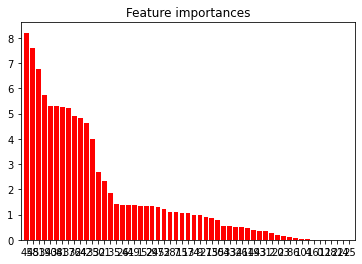

In [107]:
get_importance(cbst, cbst.get_feature_importance())

In [108]:
X_train.shape

(51704, 55)

## Тут Light auto ml


In [109]:
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 17233 17234 17235] TEST: [17236 17237 17238 ... 34467 34468 34469]
TRAIN: [    0     1     2 ... 34467 34468 34469] TEST: [34470 34471 34472 ... 51701 51702 51703]
TRAIN: [    0     1     2 ... 51701 51702 51703] TEST: [51704 51705 51706 ... 68935 68936 68937]


In [110]:
target = "IsUp60"

data_auto = snapschot.drop(["IsUp30", "IsUp1", "Difference1", "Difference30", "Difference60",
                "FutureVWAP1", "FutureVWAP30", "FutureVWAP60"], axis=1)

train_feat = []
for i in range(deep):
    train_feat += ['BidPrice'+ str(i + 1), 'BidVolume'+ str(i + 1), 'AskPrice'+ str(i + 1), 'AskVolume' + str(i + 1)]
train_feat = ['Last Trade Price', 'Last Trade Volume', 'Side', 'isNewTrade',
       'LastDealTime', 'Date', 'SMA5', 'SMA10', 'SMA30', 'SMA50',
       'SMA100', 'EMA5', 'EMA10', 'EMA30', 'EMA100', 'STD10', 'STD50',
       'STD100', 'STD1000', 'RSI14', 'RSI50', 'RSI100', 'RSI300', 'VWAP1',
       'VWAP30', 'VWAP60', 'TOP1', 'TOP30', 'TOP60', 'MIN1', 'MIN30', 'MIN60',
       'LiquidityBid', 'LiquidityAsk', 'BidLiquidityRatio']

train = {'data': data_auto[train_feat].values,
        'target': data_auto[target].values}


In [111]:
data = X_train
train_deat = X_train.columns
train = {'data': data[train_feat].values,
        'target':  y_train + 1}
test = X_test[train_feat]

In [112]:
data[train_feat].values[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 2.0210127e+07, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.3690000e+02,
       3.3690000e+02, 0.0000000e+00, 3.3610000e+02, 3.3610000e+02,
       2.8800000e+03, 2.1800000e+03, 5.6916996e-01])

In [113]:
cv_iter = TimeSeriesIterator(np.array(snapschot.Time)[train_index].astype('datetime64[ns]'), n_splits=5, sorted_kfold=False)

task = Task('multiclass', loss="f1", metric="auc")

automl = TabularAutoML(task=task, timeout=60 * 30, memory_limit=8)
oof_pred = automl.fit_predict(train, train_features=train_feat, roles={'target': target}, cv_iter=cv_iter)
# prediction can be made on file by
#test = data[train_feat]
test.to_csv('temp_test_data.csv', index=False)
test_pred = automl.predict('temp_test_data.csv', batch_size=20000, n_jobs=8)

print('Check scores...')
oof_prediction = oof_pred.data[:, 0]
not_empty = np.logical_not(np.isnan(oof_prediction))



sklearn doesn't support in general case f1 and will not be used.
cb doesn't support in general case f1 and will not be used.
Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 1800 seconds
- cpus: 4 cores
- memory: 8 gb

Train data shape: (51704, 36)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1789.9965040683746 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.9596456444848115
Linear model: C = 5e-05 score = 0.9724645214139617
Linear model: C = 0.0001 score = 0.9833185865293106
Linear model: C = 0.0005 score = 0.9992711513682834
Linear model: C = 0.001 score = 0.999298674084068
Linear model: C = 0.005 score = 0.9994009192035342
Linear model: C = 0.01 score = 0.9994082892380315
Linear model: C = 0.05 score = 0.999437380695564
Linear model: C = 0.1 score = 0.9994190787871061
Linear model: C = 0.5 score = 0.9992633008622781
Linear model: C = 1e-05 score = 0.9914769186432603
Linear model: C = 5e-05 score = 0.9986993283551978
Linear model: C = 0.0001 score = 0.9988553625192583
Linear model: C = 0.0005 score = 0.999111490772

Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's Opt metric: 0.865509
[200]	valid's Opt metric: 0.903006
[300]	valid's Opt metric: 0.916867
[400]	valid's Opt metric: 0.916867
Early stopping, best iteration is:
[284]	valid's Opt metric: 0.916867
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's Opt metric: 0.910067
[200]	valid's Opt metric: 0.95168
[300]	valid's Opt metric: 0.946926
Early stopping, best iteration is:
[192]	valid's Opt metric: 0.954075
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's Opt metric: 0.788536
[200]	valid's Opt metric: 0.808271
[300]	valid's Opt metric: 0.812259
[400]	valid's Opt metric: 0.814641
[500]	valid's Opt metric: 0.81

[1200]	valid's Opt metric: 0.99049
[1300]	valid's Opt metric: 0.991633
[1400]	valid's Opt metric: 0.992829
[1500]	valid's Opt metric: 0.993949
[1600]	valid's Opt metric: 0.994718
[1700]	valid's Opt metric: 0.995101
[1800]	valid's Opt metric: 0.995242
[1900]	valid's Opt metric: 0.995242
Early stopping, best iteration is:
[1758]	valid's Opt metric: 0.995242
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's Opt metric: 0.938419
[200]	valid's Opt metric: 0.922229
Early stopping, best iteration is:
[37]	valid's Opt metric: 0.944896
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's Opt metric: 0.941467
[200]	valid's Opt metric: 0.952989
[300]	valid's Opt metric: 0.95522
[400]	valid's Opt metric: 0.954485
Early stopping, best itera

In [114]:
data[train_feat].to_csv('temp_train_data.csv', index=False)
train_pred = automl.predict('temp_train_data.csv', batch_size=20000, n_jobs=6)

print('Check scores...')


Check scores...


In [115]:
oof_pred 

array([[3.3072919e-07, 4.7370736e-06, 9.9999493e-01],
       [4.2409130e-07, 5.5264341e-06, 9.9999404e-01],
       [4.7721636e-07, 5.6314839e-06, 9.9999392e-01],
       ...,
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan]], dtype=float32)

In [116]:
print('OOF score: {}'.format(f1_score(y_train + 1, np.argmax(train_pred.data, axis=1), average='micro')))
print('TEST score: {}'.format(f1_score(y_test + 1, np.argmax(test_pred.data, axis=1), average='micro')))

OOF score: 0.9929405848677085
TEST score: 0.5814088429847974


In [117]:
(Counter(np.argmax(train_pred.data, axis=1) -  y_train - 1), 
Counter(np.argmax(test_pred.data, axis=1) -  y_test - 1))

(Counter({0.0: 51339, -2.0: 195, -1.0: 18, 2.0: 97, 1.0: 55}),
 Counter({0.0: 10020, 2.0: 4802, -2.0: 2318, 1.0: 71, -1.0: 23}))

In [118]:
Counter(np.argmax(train_pred.data, axis=1)), Counter(y_train)

(Counter({2: 27083, 0: 23748, 1: 873}),
 Counter({1.0: 27156, -1.0: 23662, 0.0: 886}))

In [119]:
Counter(np.argmax(test_pred.data, axis=1)), Counter(y_test)

(Counter({2: 12607, 0: 4602, 1: 25}),
 Counter({1.0: 10077, -1.0: 7088, 0.0: 69}))

# AutoML вторая попытка

In [120]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.base import AutoML
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures, LGBAdvancedPipeline
from lightautoml.pipelines.features.linear_pipeline import LinearFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ModelBasedImportanceEstimator, ImportanceCutoffSelector
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler
from lightautoml.utils.timer import PipelineTimer

In [121]:
p = Profiler()
p.change_deco_settings({'enabled': True})
timer = PipelineTimer(2000, mode=2)
timer_gbm = timer.get_task_timer('gbm') # Get task timer from pipeline timer
feat_sel_0 = LGBSimpleFeatures()
mod_sel_0 = BoostLGBM(timer=timer_gbm)
imp_sel_0 = ModelBasedImportanceEstimator()
selector_0 = ImportanceCutoffSelector(feat_sel_0, mod_sel_0, imp_sel_0, cutoff=0, )

feats_gbm_0 = LGBAdvancedPipeline(top_intersections=4,
                                  output_categories=True,
                                  feats_imp=imp_sel_0)
timer_gbm_0 = timer.get_task_timer('gbm')
timer_gbm_1 = timer.get_task_timer('gbm')

gbm_0 = BoostLGBM(timer=timer_gbm_0)
gbm_1 = BoostLGBM(timer=timer_gbm_1)

tuner_0 = OptunaTuner(n_trials=20, timeout=30, fit_on_holdout=True)
gbm_lvl0 = MLPipeline([
        (gbm_0, tuner_0),
        gbm_1
    ],
    pre_selection=selector_0,
    features_pipeline=feats_gbm_0,
    post_selection=None
)

feats_reg_0 = LinearFeatures(output_categories=True,
                             sparse_ohe='auto')

timer_reg = timer.get_task_timer('reg')
reg_0 = LinearLBFGS(timer=timer_reg)

reg_lvl0 = MLPipeline([
        reg_0
    ],
    pre_selection=None,
    features_pipeline=feats_reg_0,
    post_selection=None
)

In [122]:
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 20000 # Time in seconds for automl run
TARGET_NAME = "IsUp60" # Target column name
N_THREADS = 8 # Nubmer ot threads
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [123]:
task = Task('multiclass', metric = 'crossentropy', )
reader = PandasToPandasReader(task = task, samples = None, max_nan_rate = 1, max_constant_rate = 1,
                              advanced_roles = True, drop_score_co = -1, n_jobs = 4)
blender = WeightedBlender()
automl = AutoML(reader=reader, levels=[
    [gbm_lvl0, reg_lvl0]
], timer=timer, blender=blender, skip_conn=False, verbose=1)

In [124]:
data_auto.reset_index(drop=True, inplace=True)
data_auto.head(1)

,BidPrice5,BidVolume5,BidPrice4,BidVolume4,BidPrice3,BidVolume3,BidPrice2,BidVolume2,BidPrice1,BidVolume1,...,TOP1,TOP30,TOP60,MIN1,MIN30,MIN60,LiquidityBid,LiquidityAsk,BidLiquidityRatio,IsUp60
0,335.8,1010.0,336.0,120.0,336.05,10.0,336.35,1700.0,336.75,40.0,...,0.0,336.9,336.9,0.0,336.1,336.1,2880.0,2180.0,0.56917,1.0


In [125]:
train_data, test_data = train_test_split(data_auto,
                                         test_size=TEST_SIZE,
                                         stratify=data_auto[TARGET_NAME],
                                         random_state=RANDOM_STATE)

In [126]:
%%time
oof_pred = automl.fit_predict(train_data, roles={'target': TARGET_NAME})
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[9.99948204e-01, 4.83609620e-05, 3.50321420e-06],
       [9.99809146e-01, 1.78153336e-04, 1.27168923e-05],
       [5.60549786e-03, 9.94293571e-01, 1.01045305e-04],
       ...,
       [9.99733448e-01, 2.22467163e-04, 4.40897311e-05],
       [2.45886131e-05, 9.99972224e-01, 3.22535539e-06],
       [9.99638796e-01, 3.41307983e-04, 1.99201877e-05]], dtype=float32)
Shape = (55150, 3)
CPU times: user 7min 46s, sys: 8.34 s, total: 7min 54s
Wall time: 2min 33s


In [127]:
test_pred = automl.predict(test_data)

In [128]:

print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_data[TARGET_NAME].values, oof_pred.data)))
print('TEST score: {}'.format(log_loss(test_data[TARGET_NAME].values, test_pred.data)))
print('OOF f1 score: {}'.format(f1_score(train_data[TARGET_NAME].values, -(np.argmax(oof_pred.data, axis=1) - 1), average='micro')))
print('TEST f1 score: {}'.format(f1_score(test_data[TARGET_NAME].values, -(np.argmax(test_pred.data, axis=1) - 1), average='micro')))

Prediction for test data:
array([[9.9967867e-01, 3.1269406e-04, 8.6527325e-06],
       [9.9991632e-01, 6.8210640e-05, 1.5388556e-05],
       [9.9994707e-01, 4.8385980e-05, 4.5185498e-06],
       ...,
       [6.5023465e-05, 9.9992979e-01, 5.2500873e-06],
       [9.9994689e-01, 4.8963688e-05, 4.1840171e-06],
       [5.8411890e-05, 9.9993664e-01, 4.9959963e-06]], dtype=float32)
Shape = (13788, 3)
Check scores...
OOF score: 10.293976444084437
TEST score: 10.254711286567124
OOF f1 score: 0.5386763372620127
TEST f1 score: 0.5393095445314766


In [129]:
Counter(np.argmax(oof_pred.data, axis=1) - 1), Counter(train_data[TARGET_NAME].values)

(Counter({-1: 29800, 0: 24595, 1: 755}),
 Counter({1.0: 29786, -1.0: 24600, 0.0: 764}))

In [383]:
for dat, df, name in zip([oof_pred, test_pred], [train_data, test_data], ['train', 'test']):
    print('Check aucs {0}...'.format(name))
    for cl in range(3):
        sc = roc_auc_score((df[TARGET_NAME].values == cl).astype(np.float32), dat.data[:, cl])
        print('Class {0} {1} auc score: {2}'.format(cl, name, sc))

Check aucs train...
Class 0 train auc score: 0.4158622760468321
Class 1 train auc score: 0.0011940808985278436


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
p.profile('my_report_profile.html')

# Бектест фреймворк

In [2]:
price_step = {'GAZP': .01,'SBER': .01,'AFKS': .001,'LKOH': .5, 'SNGS': .05, 'HYDR': .0001, 'TATN': .1, 'SNGSP': .005,
             'ROSN': .05,'RTKM': .01,'URKA': .01,'GMKN': 2, 'MTSS': .05, 'FEES': .00002, 'NLMK': .02, 'MGNT': .5,
             'CHMF': .2, 'VTBR': .000005, 'SBERP': .01, 'ALRS': .01, 'MAGN': .005, 'MOEX': .01, 'NVTK': .2,
             'TATNP': .1, 'IRAO': .2, 'AKRN': 2, 'PIKK': .1, 'POLY': .1, 'LSRG': .2, 'MTLR': .01}

def get_params(ml_model):
    params = dict()
    params["ml_model"] = ml_model
    params["cash"] = 50000000
    params["price_step"] = price_step
    #params["share"] = share
    return params

In [17]:
"""
Basic MM
"""


class Basic_MM_with_ML:
    def __init__(self, ml_model=0, spread=0.005, barriers=None, sma_len=300, basic_volume=30, price_step=.1, cash=1000000):
        self.name = "Basic MM with ML"
        self.cash = cash
        self.first_cash = cash
        self.equity = []
        self.time = []
        self.num_of_shares = 0
        self.spread = spread
        self.price_step = price_step
        # self.barriers = barriers
        self.sma_len = sma_len
        self.ml_model = ml_model
        self.basic_volume = basic_volume
        self.baseline_price = None
        self.ask_price_1 = 0
        self.ask_volume_1 = 0
        self.bid_price_1 = 0
        self.bid_volume_1 = 0
        self.bid_order_num = 0
        self.ask_order_num = 0
        self.bid_lst = []
        self.ask_lst = []
        self.volume_lst = []
        self.bid_last_price = None
        self.ask_last_price = None
        self.last_trade_num = None
        self.trigger_time = None
        self.latency_moex = 3
        self.algo_params = "\n\nAlgo name - " + self.name + "\nSpread - " + str(spread * 100) + "%,\n" + \
                           "SMA tick length - " + str(sma_len) + ",\n" + "Order volume - " + str(basic_volume) + \
                           ",\nSpeed of orders - " + str(self.latency_moex) + "ms."
        self.share_name = "LKOH"

    def trading(self, dom, time=100000000, first_sma=0, is_plot=False, is_PL=False):
        if not self.baseline_price:
            if first_sma == 0:
                print("no first price")
                first_sma = dom.bid.peekitem(-1)
            self.share_name = dom.share_name
            self.create_pre_trade_value(first_sma)
            return self.generate_orders()
        else:
            if len(dom.trade_log) < 3:
                if not self.share_name:
                    self.share_name = dom.share_name
                    self.algo_params = "Share name - " + dom.share_name + self.algo_params
                self.equity.append(self.cash + self.num_of_shares * self.baseline_price)
            else:
                self.equity.append(self.cash + self.num_of_shares * dom.trade_log[-1][0])
            self.time.append(time // 100000)
            self.volume_lst.append(self.num_of_shares * self.baseline_price)
            if len(dom.trade_log) > 0:
                if self.last_trade_num == dom.trade_log[-1][-2]:
                    pass
                elif self.trigger_time == None:
                    self.trigger_time = int(dom.trade_log[-1][-3]) + self.latency_moex
                elif int(self.trigger_time) + 100 > time:
                    # print("dsf")
                    pass
                else:
                    # print(time)
                    self.trigger_time = None
                    self.last_trade_num = dom.trade_log[-1][-2]
                    self.calc_bid_ask(dom.trade_log)
                    self.bid_lst.append(self.bid_price_1)
                    self.ask_lst.append(self.ask_price_1)
                    return self.generate_orders(time)
            self.bid_lst.append(self.bid_price_1)
            self.ask_lst.append(self.ask_price_1)
        return []

    def create_pre_trade_value(self, first_sma):
        self.baseline_price = first_sma
        self.ask_price_1 = myround(first_sma * (1 + self.spread / 2), base=self.price_step[self.share_name])
        self.bid_price_1 = myround(first_sma * (1 - self.spread / 2), base=self.price_step[self.share_name])
        self.ask_volume_1 = self.basic_volume
        self.bid_volume_1 = self.basic_volume

    def calc_bid_ask(self, trade_log):
        if len(trade_log) < 3:
            pass
        else:
            self.baseline_price = np.array(trade_log[-self.sma_len:])[:, 0].astype(float).mean()
            self.ask_volume_1 = self.basic_volume
            self.bid_volume_1 = self.basic_volume
            predict = self.get_predict()
            if predict == 0:
                self.ask_price_1 = myround(self.baseline_price * (1 + self.spread / 2),
                                           base=self.price_step[self.share_name])
                self.bid_price_1 = myround(self.baseline_price * (1 - self.spread / 2),
                                           base=self.price_step[self.share_name])
            elif predict == 1:
                self.ask_price_1 = myround(self.baseline_price * (1 + self.spread),
                                           base=self.price_step[self.share_name])
                self.bid_price_1 = myround(self.baseline_price,
                                           base=self.price_step[self.share_name])
            else:
                self.ask_price_1 = myround(self.baseline_price,
                                           base=self.price_step[self.share_name])
                self.bid_price_1 = myround(self.baseline_price * (1 - self.spread),
                                           base=self.price_step[self.share_name])
                
            
    def get_predict(self):
        return -1

    def generate_orders(self, time=100000000):
        bid_cancel, ask_cancel, bid_place, ask_place = dict(), dict(), dict(), dict()
        bid_cancel["BUYSELL"] = "B"
        bid_place["BUYSELL"] = "B"
        ask_cancel["BUYSELL"] = "S"
        ask_place["BUYSELL"] = "S"
        bid_cancel["ACTION"] = 0
        bid_place["ACTION"] = 1
        ask_cancel["ACTION"] = 0
        ask_place["ACTION"] = 1

        if self.bid_last_price:
            bid_cancel["PRICE"] = self.bid_last_price
            bid_cancel["ORDERNO"] = "myorder" + str(self.bid_order_num)
            ask_cancel["PRICE"] = self.ask_last_price
            ask_cancel["ORDERNO"] = "myorder" + str(self.ask_order_num)
            self.bid_order_num += 1
            self.ask_order_num += 1

        bid_place["PRICE"] = self.bid_price_1
        ask_place["PRICE"] = self.ask_price_1
        bid_place["TIME"] = time
        ask_place["TIME"] = time
        bid_place["VOLUME"] = self.bid_volume_1
        ask_place["VOLUME"] = self.ask_volume_1
        bid_place["ORDERNO"] = "myorder" + str(self.bid_order_num)
        ask_place["ORDERNO"] = "myorder" + str(self.ask_order_num)
        bid_place["NO"] = "mm"
        ask_place["NO"] = "mm"
        self.bid_last_price = self.bid_price_1
        self.ask_last_price = self.ask_price_1

        if int(self.cash) < int(self.bid_price_1 * self.bid_volume_1):
            # print("No cash")
            return [ask_cancel, ask_place]
        elif int(self.cash) > int(self.ask_price_1 * self.ask_volume_1) + 2 * int(self.first_cash):
            # print("Too much shorts")
            return [bid_cancel, bid_place]
        elif self.bid_order_num != 0:
            return [bid_cancel, ask_cancel, bid_place, ask_place]
        else:
            return [bid_place, ask_place]

    def change_cash_share(self, new_trades):
        if not new_trades or len(new_trades) == 0 or new_trades[0] == None:
            return self.cash, self.num_of_shares
        trade_log = np.array(new_trades)

        active_exec = trade_log[np.where(trade_log[:, 6] == "mm")]
        passive_exec = trade_log[np.where(trade_log[:, 3] == "mm_past")]

        if active_exec.shape[0] + passive_exec.shape[0] == 0:
            return self.cash, self.num_of_shares
        if active_exec.shape[0] > 0:
            self.num_of_shares += np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 1].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "S")][:, 1].astype(np.float))
            self.cash += np.sum(active_exec[np.where(active_exec[:, 7] == "S")][:, 4].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 4].astype(np.float))
        if passive_exec.shape[0] > 0:
            self.cash += np.sum(passive_exec[np.where(passive_exec[:, 7] == "B")][:, 4].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 4].astype(np.float))
            self.num_of_shares += np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 1].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "B")][:, 1].astype(np.float))

        return self.cash, self.num_of_shares



In [18]:
date = "20150309"
share="TATN"


Get Order log at date20150310


100%|██████████| 431148/431148 [00:10<00:00, 41028.30it/s]


Num of historic reject -  356 , algo reject -  3686
Share - TATN 2021-04-17 17:59:47.154245
--- 28.553847074508667 overall seconds ---
Stats for date - 20150310
Algo Params: 


Algo name - Basic MM with ML
Spread - 0.5%,
SMA tick length - 300,
Order volume - 30,
Speed of orders - 3ms.

Num of trades -  4076
Algo turnover -  32369709.5
P&L Gross -  198637.5
P&L Net(with commision) - 196047.9
Num of bought -  3100
Weighted average bought price -  288.8
Num of sold -  108900
Weighted average sold price -  289.0
Open Price -  296.4
Close price -  287.15
Initial cash -  50000000
Total Return - 0.4%
End Cash -  80579108.0
End Equity -  50198638.0
Max day Drawdown - -0.45%


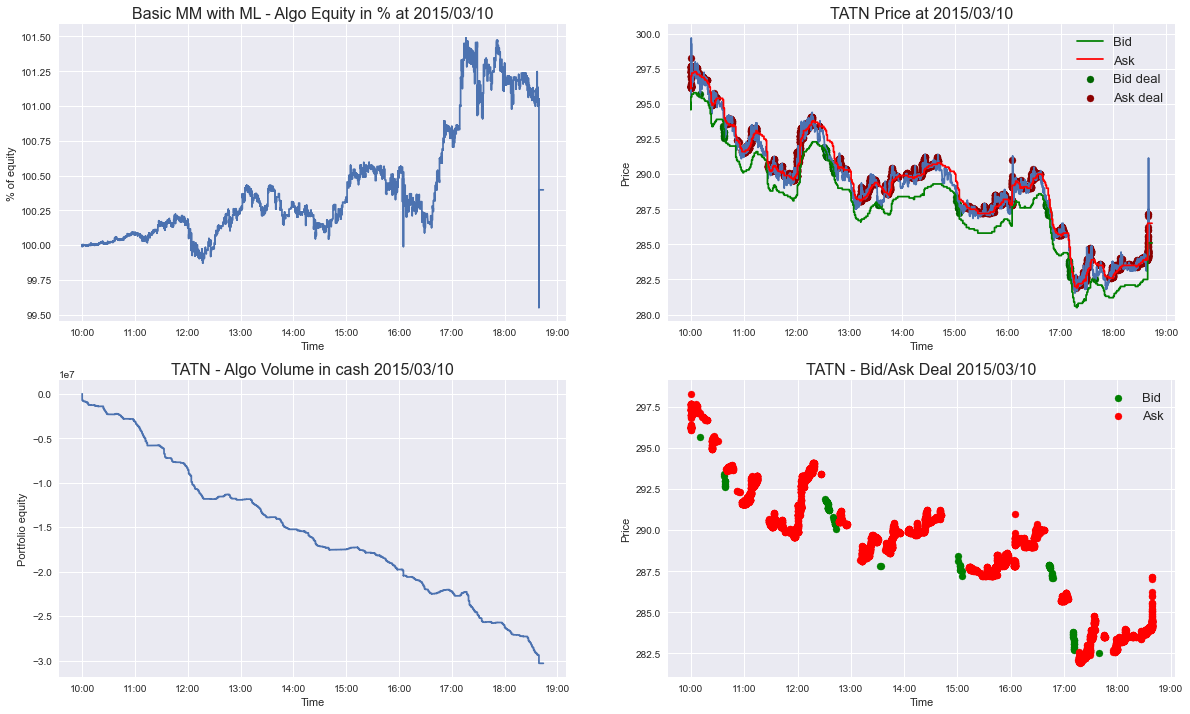

[{'Date': '20150310',
  'Num_of_trades': 4076,
  'Algo_turnover': 32369709.5,
  'P&L': 198637.5,
  'Num_of_bought': 3100,
  'WA_bought_price': 288.8,
  'Num_of_sold': 108900,
  'WA_sold_price': 289.0,
  'Open_Price': 296.4,
  'Close_price': 287.15,
  'Initial_cash': 50000000,
  'Mean_position': -13461261.607930828,
  'End_Cash': 80579107.5,
  'End_Equity': 50198637.5,
  'Max_day_drawdown': -0.45,
  'Total_Return': 0.397275}]

In [19]:
params=get_params(0)
backtest_year(date, Matching_Engine(), Basic_MM_with_ML(**params), enddate="20150311", share=share,
                                show_stat=True)

In [47]:
records[5]

{'NO': 778,
 'SECCODE': 'TATN',
 'BUYSELL': 'B',
 'TIME': 100000000,
 'ORDERNO': 778,
 'ACTION': 1,
 'PRICE': 292.4,
 'VOLUME': 10,
 'TRADENO': 'nan',
 'TRADEPRICE': nan,
 'DATE': '20150310'}